In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.preprocessing import LabelEncoder

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier


import joblib
import os



In [2]:
# Load data
Buzzfeed = pd.read_csv('data/Buzzfeed_data.csv')
Buzzfeed_title = Buzzfeed.copy()
Buzzfeed_body = Buzzfeed.copy()

top1 = pd.read_csv('data/top1_fake_title.csv').head(5)  # top 5 fake title words
top2 = pd.read_csv('data/top2_real_title.csv').head(5)  # top 5 real title words
top3 = pd.read_csv('data/top3_fake_body.csv').head(5)   # top 5 fake body words
top4 = pd.read_csv('data/top4_real_body.csv').head(5)   # top 5 real body words

In [3]:
# Convert top words to list
fake_title_words = top1['word'].tolist()
real_title_words = top2['word'].tolist()
fake_body_words = top3['word'].tolist()
real_body_words = top4['word'].tolist()
    

# Helper to count occurrences of a word
# def count_word(text, word):
#     if isinstance(text, str):
#         return len(re.findall(rf'\b{word}\b', text))
#     else:
#         return 0

def has_word(text, word):
    if isinstance(text, str):
        return 1 if re.search(rf'\b{word}\b', text) else 0
    else:
        return 0

In [102]:
Buzzfeed

,title,text,source,news_type,contain_movies,contain_images
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com,Real,0,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws,Real,0,1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com,Real,1,1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co,Real,0,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws,Real,0,1
...,...,...,...,...,...,...
177,Hillary’s TOP Donor Country Just Auctioned Off...,Hillary’s TOP Donor Country Just Auctioned Off...,http://rightwingnews.com,Fake,0,1
178,Cavuto Just Exposed Lester Holt's Lies During ...,Advertisement - story continues below\n\nThe f...,http://conservativetribune.com,Fake,1,1
179,"The AP, In 2004, Said Your Boy Obama Was BORN ...",Well THAT’S Weird. If the Birther movement is ...,http://clashdaily.com,Fake,0,1
180,People Noticed Something Odd About Hillary's O...,\n\nThere’s a lot to be discussed about last n...,http://www.thepoliticalinsider.com,Fake,0,1


In [4]:
# Create fake title word columns
for word in fake_title_words:
    col_name = f"fake_title_{word}"
    Buzzfeed_title[col_name] = Buzzfeed_title['title'].apply(lambda x: has_word(x, word))

# Create real title word columns
for word in real_title_words:
    col_name = f"real_title_{word}"
    Buzzfeed_title[col_name] = Buzzfeed_title['title'].apply(lambda x: has_word(x, word))
    

# Create fake body word columns
for word in fake_body_words:
    col_name = f"fake_body_{word}"
    Buzzfeed_body[col_name] = Buzzfeed_body['text'].apply(lambda x: has_word(x, word))

# Create real body word columns
for word in real_body_words:
    col_name = f"real_body_{word}"
    Buzzfeed_body[col_name] = Buzzfeed_body['text'].apply(lambda x: has_word(x, word))

In [5]:
# Show new columns
# Start from your Buzzfeed_title DataFrame
title = Buzzfeed_title.copy()

# Drop columns that shouldn't be used as predictors
title = title.drop(columns=['title', 'text', 'source'])

# # Convert 'source' to categorical (one-hot encoding)
# title = pd.get_dummies(title, columns=['source'], drop_first=True)

# Encode the target variable (news_type)
le = LabelEncoder()
title['news_type'] = le.fit_transform(title['news_type'])


In [6]:
# Show new columns
# Start from your Buzzfeed_body DataFrame
body = Buzzfeed_body.copy()

# Drop columns that shouldn't be used as predictors
body = body.drop(columns=['title', 'text','source'])

# # Convert 'source' to categorical (one-hot encoding)
# body = pd.get_dummies(body, columns=['source'], drop_first=True)

# Encode the target variable (news_type)
le = LabelEncoder()
body['news_type'] = le.fit_transform(body['news_type'])


In [7]:
# Define features and target
X = title.drop(columns=['news_type']) 
y = title['news_type']

# Now perform the train/test split:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
# Logistic Regression model (Forward Selection setup remains the same)
lr = LogisticRegression(max_iter=500)

# Forward Selection (choose 10 best features)
# k_features is set to 10 here, which means 10 non-'news_type' features will be selected
sfs_forward = SFS(
    lr,
    k_features=10,
    forward=True,
    floating=False,
    scoring='accuracy',
    cv=5
)

sfs_forward = sfs_forward.fit(X_train, y_train)

print("Selected Features (Forward):")
print(list(sfs_forward.k_feature_names_))

Selected Features (Forward):
['contain_movies', 'contain_images', 'fake_title_hillari', 'fake_title_clinton', 'fake_title_obama', 'fake_title_freedom', 'fake_title_daili', 'real_title_trump', 'real_title_clinton', 'real_title_donald']


In [9]:
# Full Model (all features, excluding news_type)
lr_full = LogisticRegression(max_iter=1000, solver='liblinear')
lr_full.fit(X_train, y_train)

y_pred_full = lr_full.predict(X_test)
acc_full = accuracy_score(y_test, y_pred_full)

print(f"Full Model Accuracy (Corrected): {acc_full:.4f}")

# Selected Feature Model (using SFS)
selected_features = list(sfs_forward.k_feature_names_)

# X_train and X_test are now subsetted correctly using only the selected features
X_train_sfs = X_train[selected_features]
X_test_sfs = X_test[selected_features]

lr_sfs = LogisticRegression(max_iter=1000, solver='liblinear')
lr_sfs.fit(X_train_sfs, y_train)

y_pred_sfs = lr_sfs.predict(X_test_sfs)
acc_sfs = accuracy_score(y_test, y_pred_sfs)

print(f"Selected Feature Model Accuracy (Corrected): {acc_sfs:.4f}")

improvement = acc_sfs - acc_full
print(f"Accuracy Difference (SFS - Full): {improvement:.4f}")

Full Model Accuracy (Corrected): 0.7297
Selected Feature Model Accuracy (Corrected): 0.7297
Accuracy Difference (SFS - Full): 0.0000


In [10]:
# Define features and target
X = body.drop(columns=['news_type']) 
y = body['news_type']

# Now perform the train/test split:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
# Logistic Regression model (Forward Selection setup remains the same)
lr = LogisticRegression(max_iter=500)

# Forward Selection (choose 10 best features)
# k_features is set to 10 here, which means 10 non-'news_type' features will be selected
sfs_forward = SFS(
    lr,
    k_features=10,
    forward=True,
    floating=False,
    scoring='accuracy',
    cv=5
)

sfs_forward = sfs_forward.fit(X_train, y_train)

# Full Model (all features, excluding news_type)
lr_full = LogisticRegression(max_iter=1000, solver='liblinear')
lr_full.fit(X_train, y_train)

y_pred_full = lr_full.predict(X_test)
acc_full = accuracy_score(y_test, y_pred_full)

print(f"Full Model Accuracy (Corrected): {acc_full:.4f}")

# Selected Feature Model (using SFS)
selected_features = list(sfs_forward.k_feature_names_)

# X_train and X_test are now subsetted correctly using only the selected features
X_train_sfs = X_train[selected_features]
X_test_sfs = X_test[selected_features]

lr_sfs = LogisticRegression(max_iter=1000, solver='liblinear')
lr_sfs.fit(X_train_sfs, y_train)

y_pred_sfs = lr_sfs.predict(X_test_sfs)
acc_sfs = accuracy_score(y_test, y_pred_sfs)

print(f"Selected Feature Model Accuracy (Corrected): {acc_sfs:.4f}")

improvement = acc_sfs - acc_full
print(f"Accuracy Difference (SFS - Full): {improvement:.4f}")

Full Model Accuracy (Corrected): 0.6757
Selected Feature Model Accuracy (Corrected): 0.6757
Accuracy Difference (SFS - Full): 0.0000


In [12]:
X = title.drop(columns=['news_type']) 
y = title['news_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define the new set of models for comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    
    # Ensemble Methods
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42), 
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "Bagging (DT)": BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42), 
        n_estimators=100, 
        random_state=42
    ),
    
    # Baseline
    "K-Nearest Neighbors (k=5)": KNeighborsClassifier(n_neighbors=5)
}

results = []

# Loop through models and evaluate (Your existing loop structure)
print("Running model training and evaluation...")
for name, model in models.items():
    # Train the full model on X_train
    model.fit(X_train, y_train)
    
    # Predict on the hold-out test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results.append({
        "Model": name,
        "Accuracy": accuracy
    })

# Create Comparison DataFrame
comparison_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n--- New Model Accuracy Comparison ---")
print(comparison_df)


Running model training and evaluation...

--- New Model Accuracy Comparison ---
                       Model  Accuracy
0        Logistic Regression  0.702703
1              Random Forest  0.702703
2          Gradient Boosting  0.702703
3               Bagging (DT)  0.702703
4  K-Nearest Neighbors (k=5)  0.513514


In [ ]:
# Define the 5 Models (as used in last comparison) 
models_to_plot = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42), 
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "Bagging (DT)": BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42), 
        n_estimators=100, 
        random_state=42
    )
}

# --- 2. Train Models and Get Predictions (Re-running the fit on X_train/y_train) ---
# This ensures we have the correct predictions for plotting.
all_preds = {}
print("\nGenerating predictions for confusion matrix plots...")

# Assuming X_train, X_test, y_train, y_test are available from the previous block
for name, model in models_to_plot.items():
    model.fit(X_train, y_train)
    all_preds[name] = model.predict(X_test)

# --- 3. Generate and Plot Confusion Matrices (3x2 Layout) ---
# We use 3 rows and 2 columns. The 6th spot will be empty.
fig, axes = plt.subplots(2, 2, figsize=(15, 15)) 
plt.suptitle('Confusion Matrices Comparison (Engineered Features)', fontsize=18, y=1.02)
axes = axes.flatten() # Flattens the 2x2 grid of axes into a 1D array for easy iteration

# Assuming 0=Fake, 1=Real
class_names = ['Fake', 'Real'] 

for i, (name, y_pred) in enumerate(all_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[i]
    
    # Calculate the accuracy for the title
    acc = accuracy_score(y_test, y_pred)
    
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False,
        xticklabels=class_names, 
        yticklabels=class_names, 
        ax=ax
    )
    
    ax.set_title(f'{name}\nAccuracy: {acc:.4f}', fontsize=14)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Hide the last (empty) subplot
fig.delaxes(axes[5]) 

plt.tight_layout()
plt.savefig('confusion_matrices_2x2_comparison.png')
plt.close()

print("\nConfusion matrices visualization saved as 'confusion_matrices_2x2_comparison.png'")


Generating predictions for confusion matrix plots...


IndexError: index 5 is out of bounds for axis 0 with size 4

In [15]:
# We will test k values from 1 up to 20. Odd numbers are usually preferred for binary classification.
param_grid = {
    'n_neighbors': np.arange(1, 21),  # Test k from 1 to 20
    'weights': ['uniform', 'distance'] # Also check uniform vs. distance weighting
}

# Use Stratified K-Fold to ensure the proportion of Real/Fake news is maintained in each fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',  # Use accuracy as the metric to optimize
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1  # Use all available cores for faster processing
)

print("Starting Grid Search for optimal K...")
grid_search.fit(X_train, y_train) 

best_k = grid_search.best_params_['n_neighbors']
best_weights = grid_search.best_params_['weights']
best_score = grid_search.best_score_

print("\n--- Cross-Validation Results ---")
print(f"Optimal K (n_neighbors): {best_k}")
print(f"Optimal Weights: {best_weights}")
print(f"Cross-Validated Accuracy: {best_score:.4f}")

Starting Grid Search for optimal K...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

--- Cross-Validation Results ---
Optimal K (n_neighbors): 17
Optimal Weights: uniform
Cross-Validated Accuracy: 0.5103


In [16]:
# 1. Define the Optimized KNN Model
# Use the best parameters found by the Grid Search cross-validation
knn_optimized = KNeighborsClassifier(
    n_neighbors=best_k, 
    weights=best_weights
)

# 2. Train the Model (on the entire training set)
print(f"Training optimized KNN model with K={best_k} and weights='{best_weights}'...")
knn_optimized.fit(X_train, y_train)

# 3. Predict on the Test Set
y_pred_optimized = knn_optimized.predict(X_test)

# 4. Calculate Final Test Accuracy
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

print("\n--- Optimized K-Nearest Neighbors Results ---")
print(f"Test Accuracy (Optimal K={best_k}): {accuracy_optimized:.4f}")

Training optimized KNN model with K=17 and weights='uniform'...

--- Optimized K-Nearest Neighbors Results ---
Test Accuracy (Optimal K=17): 0.5135


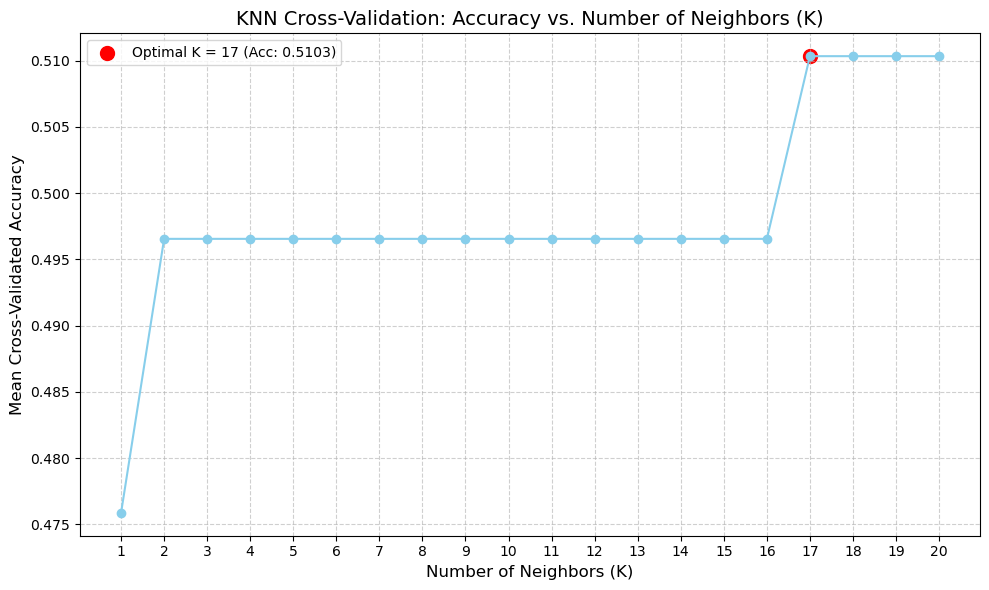

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming the 'grid_search' object is available from the previous step
results = pd.DataFrame(grid_search.cv_results_)

# Filter results for the best weight ('uniform') and extract k values and scores
best_weights = 'uniform' 
filtered_results = results[results['param_weights'] == best_weights]

# Extract mean scores and the k values
mean_scores = filtered_results['mean_test_score']
k_values = filtered_results['param_n_neighbors'].apply(lambda x: x)

# Find the best score index
best_k_index = np.argmax(mean_scores)

# --- Plotting Code ---
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_scores, marker='o', linestyle='-', color='skyblue')

# Highlight the best K=17
plt.scatter(
    k_values.iloc[best_k_index], 
    mean_scores.iloc[best_k_index], 
    color='red', 
    s=100, 
    label=f'Optimal K = {k_values.iloc[best_k_index]} (Acc: {mean_scores.iloc[best_k_index]:.4f})'
)

plt.title('KNN Cross-Validation: Accuracy vs. Number of Neighbors (K)', fontsize=14)
plt.xlabel('Number of Neighbors (K)', fontsize=12)
plt.ylabel('Mean Cross-Validated Accuracy', fontsize=12)
plt.xticks(k_values, rotation=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
try:
    import tensorflow as tf
    print(f"TensorFlow is installed. Version: {tf.__version__}")
except ImportError:
    print("TensorFlow is NOT installed. You can install it using: pip install tensorflow")

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Split the data 
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    Buzzfeed['title'], Buzzfeed['news_type'], test_size=0.2, random_state=42, stratify=Buzzfeed['news_type']
)

# 2. Tokenize the text 
max_words = 10000  # Vocabulary size
tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(X_train_raw)

# 3. Convert text to sequences and pad
maxlen = 20 # Maximum length for a title
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

: 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Model parameters
embedding_dim = 100

# Build the LSTM model
model = Sequential([
    # Input layer: Turns index sequence into dense vectors (embeddings)
    Embedding(max_words, embedding_dim, input_length=maxlen), 
    
    # LSTM layer: The core recurrent layer to capture sequential information
    LSTM(64), 
    
    # Dropout for regularization (to prevent overfitting)
    Dropout(0.5), 
    
    # Output layer: Sigmoid activation for binary classification (Real/Fake)
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model (Using 10 epochs as a starting point)
history = model.fit(
    X_train_pad, 
    y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=(X_test_pad, y_test)
)

# Evaluate on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\nLSTM Model Test Accuracy: {accuracy:.4f}")

In [95]:
# Text Preprocessing Functions

ps = PorterStemmer()
wst = WhitespaceTokenizer()

# Lowercase
def lower_func(x):
    return x.lower()

# Remove numbers
def remove_number_func(x): 
    return ''.join([a for a in x if not a.isdigit()])

# Remove punctuation
def remove_punc_func(x):
    return ''.join([a for a in x if a not in string.punctuation])

# Remove special characters
def remove_spec_char_func(x):
    return ''.join([a for a in x if a.isalnum() or a == ' '])

# Remove English stopwords (using sklearn)
def remove_stopwords(x):
    new = []
    for a in x.split():
        if a not in ENGLISH_STOP_WORDS:
            new.append(a)
    return " ".join(new)

# Stemming
def stem_func(x):
    wordlist = word_tokenize(x)
    psstem = [ps.stem(a) for a in wordlist]
    return ' '.join(psstem)

# Remove extra whitespaces
def remove_whitespace_func(x):
    return(wst.tokenize(x))

# Function composition helper
def compose(f, g):
    return lambda x: f(g(x))

# Final preprocessing pipeline
final = compose(
    compose(
        compose(
            compose(
                compose(
                    compose(remove_whitespace_func, stem_func),
                    remove_stopwords
                ),
                remove_spec_char_func
            ),
            remove_punc_func
        ),
        remove_number_func
    ),
    lower_func
)

In [96]:
# Split features and target
X = Buzzfeed['title']  
y = Buzzfeed['news_type']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocessing + RandomForest pipeline
pp = Pipeline([
    ('bow', CountVectorizer(analyzer=final)),  # final is your preprocessing function
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit model
pp.fit(X_train, y_train)

# Predictions
predictions = pp.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[13 15]
 [ 3 24]]
              precision    recall  f1-score   support

        Fake       0.81      0.46      0.59        28
        Real       0.62      0.89      0.73        27

    accuracy                           0.67        55
   macro avg       0.71      0.68      0.66        55
weighted avg       0.72      0.67      0.66        55



In [97]:
# Split features and target
X = Buzzfeed['text']  
y = Buzzfeed['news_type']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocessing + RandomForest pipeline
pp = Pipeline([
    ('bow', CountVectorizer(analyzer=final)),  # final is your preprocessing function
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit model
pp.fit(X_train, y_train)

# Predictions
predictions = pp.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[19  9]
 [ 8 19]]
              precision    recall  f1-score   support

        Fake       0.70      0.68      0.69        28
        Real       0.68      0.70      0.69        27

    accuracy                           0.69        55
   macro avg       0.69      0.69      0.69        55
weighted avg       0.69      0.69      0.69        55



In [98]:
# Define models to compare
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "NaiveBayes": MultinomialNB(),
    "SVM": SVC(kernel='linear', random_state=42)
}

# Feature types
feature_types = {
    "Title": Buzzfeed['title'],
    "Body": Buzzfeed['text']
}

results = []

for feat_name, X in feature_types.items():
    y = Buzzfeed['news_type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('bow', CountVectorizer(analyzer=final)),
            ('tfidf', TfidfTransformer()),
            ('clf', model)
        ])
        
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)
        
        results.append({
            "Feature": feat_name,
            "Model": model_name,
            "Accuracy": accuracy_score(y_test, preds),
            "Precision": precision_score(y_test, preds, pos_label='Real'),
            "Recall": recall_score(y_test, preds, pos_label='Real'),
            "F1": f1_score(y_test, preds, pos_label='Real')
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Pivot table to show only accuracy
accuracy_df = results_df.pivot(index='Model', columns='Feature', values='Accuracy')
accuracy_df = accuracy_df.reset_index()
accuracy_df

Feature,Model,Body,Title
0,LogisticRegression,0.781818,0.690909
1,NaiveBayes,0.763636,0.618182
2,RandomForest,0.690909,0.672727
3,SVM,0.818182,0.654545


In [99]:
# Pivot table to show only accuracy
accuracy_df = results_df.pivot(index='Model', columns='Feature', values='Accuracy')
accuracy_df = accuracy_df.reset_index()
accuracy_df

Feature,Model,Body,Title
0,LogisticRegression,0.781818,0.690909
1,NaiveBayes,0.763636,0.618182
2,RandomForest,0.690909,0.672727
3,SVM,0.818182,0.654545


In [100]:
# lambda cause error to download  
def finals(text):
    text = lower_func(text)
    text = remove_number_func(text)
    text = remove_punc_func(text)
    text = remove_spec_char_func(text)
    text = remove_stopwords(text)
    text = stem_func(text)
    text = ' '.join(remove_whitespace_func(text))
    return text

# Split features and target
X = Buzzfeed['text']  
y = Buzzfeed['news_type']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Preprocessing + SVM pipeline
svm_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=finals)),  # your preprocessing function
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC(kernel='linear', random_state=42))
])

# Fit model
svm_pipeline.fit(X_train, y_train)


# Path to folder
os.makedirs('data', exist_ok=True)

# Save your trained pipeline inside the data folder
joblib.dump(svm_pipeline, 'data/svm_body_model.pkl')

['data/svm_body_model.pkl']